# derive true $\bar{F}$

In [1]:
import os
import pickle
import numpy as np

import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
niter = 3

models = [] 
for imodel in range(1): 
    # load model
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.i%i.pt' % niter)
    models.append(_models[0])

spec, w, z, target_id, norm = [], [], [], [], []
true_cont = [] 

for ibatch in range(50): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _spec, _w, _z, _target_id, _norm, zerr = pickle.load(f)
    spec.append(np.array(_spec))
    w.append(np.array(_w))
    z.append(np.array(_z))
    target_id.append(np.array(_target_id))    
    norm.append(np.array(_norm))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))

spec = np.concatenate(spec, axis=0)
w = np.concatenate(w)
z = np.concatenate(z)
target_id = np.concatenate(target_id)
norm = np.concatenate(norm)

true_cont = np.concatenate(true_cont, axis=0)

In [6]:
wave_rest_rebin = np.linspace(800, 3000, 2000)

In [10]:
barF_rest = np.zeros(len(wave_rest_rebin))
nwbin = np.zeros(len(wave_rest_rebin))

for igal in range(len(z)): 
    # rebinning for picca
    wlim = (wave_rest_rebin > 3.7e3/float(1+z[igal])) & (wave_rest_rebin < 9.7e3/float(1+z[igal]))

    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]), 
        xnew=wave_rest_rebin[wlim])

    # rebin picca
    spec_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs)/float(1+z[igal]), 
        np.array(spec[igal]), 
        xnew=wave_rest_rebin[wlim])
        
    barF_rest[wlim] += spec_rebin / (true_rebin / norm[igal])
    nwbin[wlim] += 1
    
#barC_rest /= nwbin
barF_rest /= nwbin

/tmp/ipykernel_882716/2769814632.py:23: RuntimeWarning: invalid value encountered in divide
  barF_rest /= nwbin


(800.0, 1500.0)

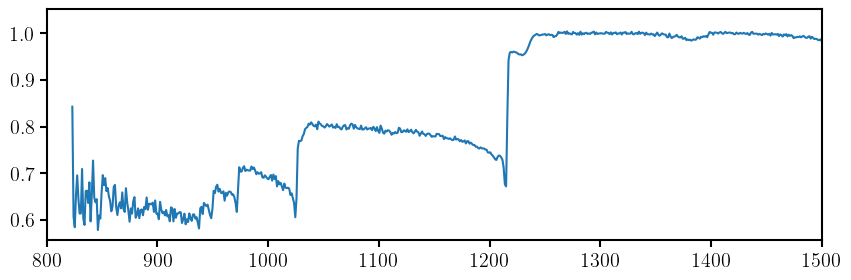

In [23]:
fig = plt.figure(figsize=(10,3))
sub = fig.add_subplot(111)
sub.plot(wave_rest_rebin, barF_rest)
sub.set_xlim(800, 1500)

In [24]:
np.save('barF_all.npy', barF_rest)

# no BAL/DLA

In [16]:
niter = 3

spec, w, z, target_id, norm = [], [], [], [], []
true_cont = [] 

for ibatch in range(37): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.no_bal_dla.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _spec, _w, _z, _target_id, _norm, zerr = pickle.load(f)
    spec.append(np.array(_spec))
    w.append(np.array(_w))
    z.append(np.array(_z))
    target_id.append(np.array(_target_id))    
    norm.append(np.array(_norm))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.no_bal_dla.true_cont.npy' % (ibatch)))

spec = np.concatenate(spec, axis=0)
w = np.concatenate(w)
z = np.concatenate(z)
target_id = np.concatenate(target_id)
norm = np.concatenate(norm)

true_cont = np.concatenate(true_cont, axis=0)

In [17]:
barF_nobaldla_rest = np.zeros(len(wave_rest_rebin))
nwbin = np.zeros(len(wave_rest_rebin))

for igal in range(len(z)): 
    # rebinning for picca
    wlim = (wave_rest_rebin > 3.7e3/float(1+z[igal])) & (wave_rest_rebin < 9.7e3/float(1+z[igal]))

    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]), 
        xnew=wave_rest_rebin[wlim])

    # rebin picca
    spec_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs)/float(1+z[igal]), 
        np.array(spec[igal]), 
        xnew=wave_rest_rebin[wlim])
        
    barF_nobaldla_rest[wlim] += spec_rebin / (true_rebin / norm[igal])
    nwbin[wlim] += 1
    
barF_nobaldla_rest /= nwbin

/tmp/ipykernel_882716/369606151.py:22: RuntimeWarning: invalid value encountered in divide
  barF_nobaldla_rest /= nwbin


Text(0, 0.5, '$\\bar{F}(\\lambda)$')

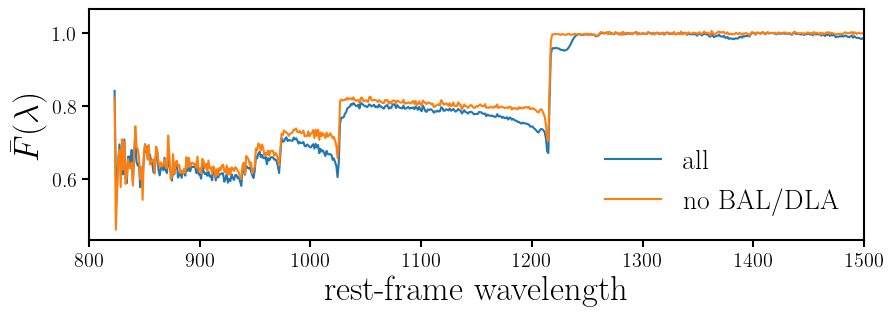

In [21]:
fig = plt.figure(figsize=(10,3))
sub = fig.add_subplot(111)
sub.plot(wave_rest_rebin, barF_rest, label='all')
sub.plot(wave_rest_rebin, barF_nobaldla_rest, label='no BAL/DLA')
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('rest-frame wavelength', fontsize=25)
sub.set_xlim(800, 1500)
sub.set_ylabel(r'$\bar{F}(\lambda)$', fontsize=25)

In [22]:
np.save('barF_nobaldla.npy', barF_nobaldla_rest)